# ECE 57000 Assignment 6 Exercise

Your Name: Roshan Sundar

Objective: Build an RNN model to predict the next character in a sequence of text data from Shakespeare's plays.

# Exercise  1: Data Preprocessing (30 points)
In this part, you will implement some preprocessing functions.
Run the following code to load the text data from the given file "shakespeare.txt". Do not change the random seed.

In [3]:
import numpy as np
! pip install unidecode
import unidecode
import string
import time
import torch
import pdb

import torch.nn as nn
from torch.autograd import Variable
np.random.seed(123)

all_characters = string.printable
print(all_characters)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.3 MB/s eta 0:00:00
0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	



Follow the step on the instructions and mount your google drive on Colab which allows to access the .txt file uploaded on your drive that was included with this assignment.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file

dir_root = '/content/drive/MyDrive/Colab Notebooks/ECE570/Assignment-6'     # Your assignment dir
file_path = dir_root + '/shakespeare.txt'
file = read_file(file_path)
file_len = len(file)
print(f"file length: {file_len}")
print(file[:100])

file length: 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


### Task 1: Implement function to get a random chunk of Shakespeare text (15 points)
The `get_random_chunk` function is a helper function that generates a random chunk of **input text data** and **output text data** (which is one character shifted from the input) from the Shakespeare dataset.
Specifically, the `chunk_len` argument specifies the size of the input and output sequences.
For example, if `chunk_len=4`, then a valid return value would be the two chunks:
`('Befo','efor')` or `('proc','roce')`.
This function is useful
in generating diverse sets of input data for training the RNN model in the assignment.

Hints:
- Start from a random index of the file (but note that the max index must be small enough so that a full chunk can be extracted).
- Based on this random start index, extract `chunk_len` characters for the input sequence and `chunk_len` characters for the output sequence (shifted one character to the right).

In [7]:
def get_random_chunk(file, chunk_len = 100):
    ######### Your Code Here ###########
    text = file
    if len(text) < chunk_len + 1:
      print("File is too small")
    start_i = np.random.randint(0, len(text) - chunk_len - 1)
    end_i = start_i + chunk_len
    curr_chunk = text[start_i : (end_i)]
    next_chunk = text[(start_i + 1) : (end_i + 1)]

    return curr_chunk, next_chunk
    ######### End of your code #########

curr_chunk, next_chunk = get_random_chunk(file='Hello world!', chunk_len=10)
print(f"curr_chunk =>{curr_chunk}\n next_chunk=> {next_chunk}")

print(f"Is curr_chunk and next_chunk same length: {len(curr_chunk) == len(next_chunk)}")
print(f"Is next chunk shifted by one: {curr_chunk[1:] == next_chunk[:-1]}")


curr_chunk =>Hello worl
 next_chunk=> ello world
Is curr_chunk and next_chunk same length: True
Is next chunk shifted by one: True


### Task 2: Implement function to convert to tensors (15 points)

Define a function `to_tensor(string)` that takes a string of characters as input and return torch tensor as output, similar to in the demo in class.
Specifically,
1. Create an empty tensor of shape `(len(string), 1, len(all_characters))` using the PyTorch `torch.zeros` function,
    where `len(string)` is the length of the input string, 1 is the batch size, and `len(all_characters)` is the total
    number of unique characters in the text data.
2. Loop through each character in the input string and convert it to a one-hot encoded vector.

In [12]:
def to_tensor(string):
######### Your Code Here ###########
  tensor = torch.zeros(len(string), 1, len(all_characters))
  for li, letter in enumerate(string):
    tensor[li][0][all_characters.find(letter)] = 1
  return tensor
######### End of your code #########

def get_one_hot_tensors(input, output):
    return to_tensor(input), to_tensor(output)

input, output = get_random_chunk(file, 50)
print(input.replace('\n', ' '))
print(output.replace('\n', ' '))
input_tensor, output_tensor = get_one_hot_tensors(input, output)
print(f"input shape: {input_tensor.shape}")
print(f"output shape: {output_tensor.shape}")

's nothing differs but the outward fame.  First Mu
s nothing differs but the outward fame.  First Mur
input shape: torch.Size([50, 1, 100])
output shape: torch.Size([50, 1, 100])


# Exercise  2: Build the RNN model (30 points)

In this part, you will build the RNN model using PyTorch.
- nn.GRU is used to implement the GRU algorithm for processing sequential input data.
    - https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
- The decoder layer is a fully connected neural network layer that maps the output of the GRU layer to the desired output size.
- As we are only implementing a single layer RNN, the model is not powerful enough to learn long-term dependencies in the text data. So don't be surprised if the output sentences are not very meaningful. We are providing you loss plots (`gru_loss_ex2.png`) to help you check if your code is working correctly.

In [13]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        # Define modules of RNN
        ######### Your Code Here ###########
        # Set `self.rnn_cell` to a nn.GRU
        self.rnn_cell = nn.GRU(input_size, hidden_size, n_layers)
        # Define a linear decoder layer that maps from the hidden size to the output size
        self.decoder = nn.Linear(hidden_size, output_size)
        ######### End of your code #########

    def forward(self, input, hidden):
        ######### Your Code Here ###########
        # 1. Reshape the input to (1, 1, -1) and pass it to the GRU layer
        # 2. Reshape the rnn_cell output to (1, -1) and pass it to the decoder layer
        input = input.view(1, 1, -1)
        output, hidden = self.rnn_cell(input, hidden)
        output = output.view(1, -1)
        output = self.decoder(output)
        ######### End of your code #########
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [14]:
def train(inp, target, decoder):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    input_tensor, target_tensor = get_one_hot_tensors(inp, target)
    for c in range(len(inp)):
        output, hidden = decoder(input_tensor[c], hidden)
        loss += criterion(output, torch.argmax(target_tensor[c]).unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()
    return loss.item() / max_length

In [15]:
def evaluate(decoder, prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = to_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        out, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = to_tensor(predicted_char)

    return predicted

[(100 5.0%) 2.662528076171875]
Whe me sgim't or whg mad sote por, yacmnor anivr mit touret mangre tland Go wes,

M gi belo scds nge d 

[(200 10.0%) 2.2037904357910154]
Whosar rredd sove med aroun ta tat lnd fot ', pt an fos, tles thilr ter wanose doulns

ImS weold of fo 

[(300 15.0%) 2.2480850219726562]
Whouco gherende thean the, hed the, moars me; fouret, in hot hey thas sore,

Ass are wald brdl foll ti 

[(400 20.0%) 2.3469525146484376]
Whak mo thes te your so thee, fore thang se?

LINGEN
ELV:
Ardapofie fe, me,
I the there rese t he thes 

[(500 25.0%) 2.220806121826172]
Whis was gericcin;
Thell toull Hand wath piversuss he atr mir farel?

IELII INGNG MIELI Shir for thel  

[(600 30.0%) 1.9318476867675782]
Why uve saak
Yoted the fur the thes ir that, Fortime; are.
To beadstuiss he mesimt, at su Hathise cous 

[(700 35.0%) 2.457444763183594]
What bous its thes his benthers of mastr hom ig the int bores om come to Canesand.

CARID:
Of cawnder' 

[(800 40.0%) 2.1079087829589844]
Whour

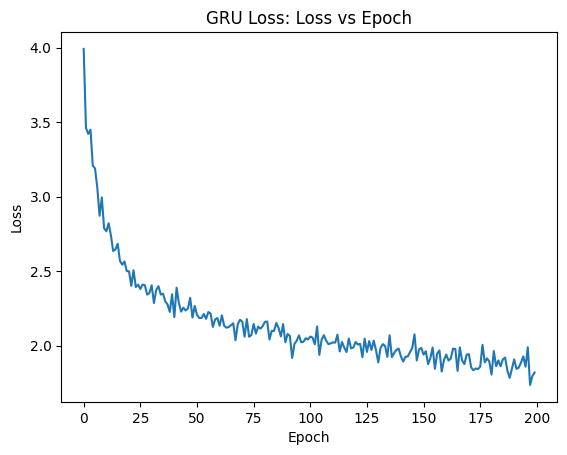

In [16]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005
max_length = len(all_characters)

decoder = RNN(max_length, hidden_size, max_length)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*get_random_chunk(file), decoder)
    loss_avg += loss

    if epoch % print_every == 0:
        print(f"[({epoch} {epoch / n_epochs * 100}%) {loss}]")
        print(evaluate(decoder, 'Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

print(f"______________________________________________________________")
print(evaluate(decoder, 'Th', 200, temperature=0.2))

import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.title("GRU Loss: Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Exercise  3: Implement an LSTM model (30 points)

Using the equations from the slides in class, write your own LSTM cell module.
The code below will use this instead of the GRU cell module and train the model.

Notes:
- Note that for LSTM the hidden state is really both the $h_t$ and $C_t$ so we just unpack the passed hidden state into these two variables at the beginning, and pack them into a tuple for returning.
- We apply a single linear layer to compute all the linear parts of the model that operate on $h'_{t-1}$ and then unpack these using `chunk(4)` into the four separate parts. This is equivalent to having 4 separate linear layers.
- As we are only implementing a single layer RNN, the model is not powerful enough to learn long-term dependencies in the text data. So don't be surprised if the output sentences are not very meaningful. We are providing you loss plots (`lstm_loss_ex3.png`) to help you check if your code is working correctly.

In [17]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.xh = nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.hh = nn.Linear(hidden_size, hidden_size * 4, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hidden=None):
        # Unpack hidden state and cell state
        hx, cx = hidden

        # Apply linear layers to input and hidden state
        linear = self.xh(input) + self.hh(hx)

        # Get outputs of applying a linear transform for each part of the LSTM
        input_linear, forget_linear, cell_linear, output_linear = linear.reshape(-1).chunk(4)

        ######### Your Code Here ###########
        # 1. Apply activation functions to get gates and new cell state information
        # 2. Calculate the new cell state (c_new)
        # 3. Calculate the new hidden state (h_new)

        input_gate = torch.sigmoid(input_linear)
        forget_gate = torch.sigmoid(forget_linear)
        cell_gate = torch.tanh(cell_linear)
        output_gate = torch.sigmoid(output_linear)

        c_new = (forget_gate * cx) + (input_gate * cell_gate)

        h_new = output_gate * torch.tanh(c_new)




        ######### End of your code #########

        # Pack cell state $C_t$ and hidden state $h_t$ into a single hidden state tuple
        output = h_new # For LSTM the output is just the hidden state
        hidden = (h_new, c_new) # Packed h and C
        return output, hidden



[(100 5.0%) 3.1158221435546873]
WhLest:hnstd unmtsynpe t pe e htr Ionsnh  nhmeals ueo heouif ottryl so riggae ashh
inh
y o rd Iehoo  n 

[(200 10.0%) 3.5085708618164064]
WhfUh l lI  et b
Fh nrhe i, itaeee
a d u ne ne  ieo t llfo teer h :  Iyl u l Iu  rsd , du rRseur f aoa 

[(300 15.0%) 3.087442626953125]
WhJ aUob IlaB  o.i 
f te dph yh: tooowhbmo i nge 
iwatm r aslo drorw pe

smee rWy ot dwh u ect 
nd  hr 

[(400 20.0%) 3.103599853515625]
Wh-cae ctwcae auiE tgowTo?
.
Ad eel:a gene: dod tee twhnmd Gorse  hns haet,uonhn hdoo Irrs mtit yme ho 

[(500 25.0%) 2.719429931640625]
WhSard
r d ne aion qa: toal ror wna saee asy atouwn emeraer
RLTai ttos haeos us id peit do eatnton ess 

[(600 30.0%) 2.6923138427734377]
Whro, ,o dou se tend hoe hee thad iouns brnthbr
'oarrye
pbvrd bote wil .h-u i'ed
 hest atnon th;ryat w 

[(700 35.0%) 2.6565701293945314]
Whey hettefuwle.

BoE,
RiTI,rKiwA eas de, bor manss cimens plordseu hin tofdref thlore mebantelh metth 

[(800 40.0%) 2.663111572265625]
Whour 

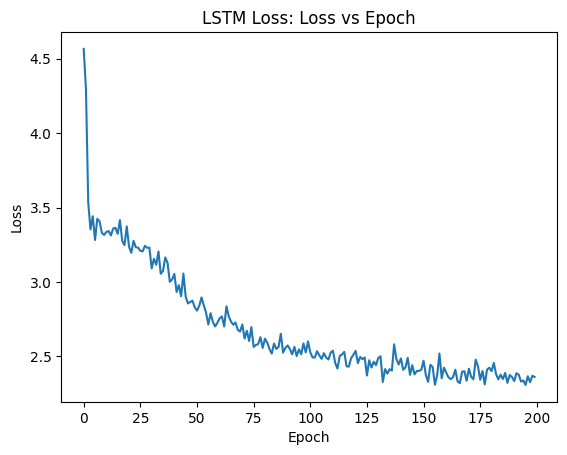

In [18]:
lr = 0.001
class LSTM_RNN(RNN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Replace the gru cell with LSTM cell
        self.rnn_cell = LSTMCell(max_length, hidden_size, max_length)

    def init_hidden(self):
        # LSTM cells need two hidden variables in a tuple of (h_t,C_t)
        return (Variable(torch.zeros(1, 1, self.hidden_size)), Variable(torch.zeros(1, 1, self.hidden_size)))

decoder = LSTM_RNN(max_length, hidden_size, max_length)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)

all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*get_random_chunk(file),decoder)
    loss_avg += loss

    if epoch % print_every == 0:
        print(f"[({epoch} {epoch / n_epochs * 100}%) {loss}]")
        print(evaluate(decoder, 'Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

print(f"______________________________________________________________")
print(evaluate(decoder, 'Th', 200, temperature=0.2))

plt.plot(all_losses)
plt.title("LSTM Loss: Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Exercise 4: Implement your own GRU (10 points)

Same as above but implement a GRU instead of an LSTM module. An exmaple of GRU architecture can be found from the lecture slide: https://www.davidinouye.com/course/ece57000-fall-2023/lectures/recurrent-neural-networks.pdf

You output loss plot should be similar in Exercise 2.

In [24]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.h2z = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2r = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2h = nn.Linear(input_size + hidden_size, hidden_size)

        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        # Inputs:
        #       input: of shape (batch_size, input_size)
        #       hx: of shape (batch_size, hidden_size)
        # Output:
        #       h_t, h_t: h_t is of shape (batch_size, hidden_size)

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))

        ######### Your Code Here ###########

        # Concatenate hidden and input to get h_prime (see torch.cat)
        h_prime = torch.cat((hx, input), dim=1)
        h_prime = h_prime.view(1, -1)
        # Use self.h2z to calculate z_t
        z_t = torch.sigmoid(self.h2z(h_prime))
        # Use self.h2r to calculate r_t
        r_t = torch.sigmoid(self.h2r(h_prime))
        # Use Hadamard product of r_t and hx and concatenate with input
        # Then use h2h to calculate new hidden information h_tbar
        hr_t = r_t * hx
        h_input = torch.cat((input, hr_t), dim=-1)
        h_tbar = torch.tanh(self.h2h(h_input))
        # Update h_t with z_t, hx, and h_tbar
        h_t = (1 - z_t) * hx + z_t * h_tbar


        ######### End of your code #########

        # Reshape h_t match input size
        h_t = h_t.reshape(1, 1, -1)

        return h_t, h_t   # Output and hidden are both h_t

[(100 5.0%) 3.2271298217773436]
Whug tomtae tha. itr,
iioetn
fter=mii
d tou


-rar,
CfHk, chad mong, eet ink land sh tr thiuhe the, 
h 

[(200 10.0%) 2.326057891845703]
Wha cees afrastel, lamering beae sot thour myi; she then me doud poon ficf hereU
My bot you cele sons  

[(300 15.0%) 2.136103057861328]
Whe the no fou the Robeisilt
Whall fake that matert ary.

CORIO:
I GI IUCILI?
The rato me? thes tats o 

[(400 20.0%) 2.2535054016113283]
Whe the sor's co liche allear
Jo come, I nowr, hand ssterting if a bisttandullle nifrhe aom and han th 

[(500 25.0%) 2.0261981201171877]
Wher if ald of the foren, dist wht the ath this whome and shato lot and a to gome couft wins!

KTERPEN 

[(600 30.0%) 2.2046168518066405]
Whings!
Cave with hart you deave with tor sare Cor chancting wiri gougebe-son--
ONow broy's lave I the 

[(700 35.0%) 2.2051742553710936]
Wher ablourte thee treme.

Carkeed sare his:
A thour bereme thour deame brothe bester poor thitherace; 

[(800 40.0%) 2.1884591674804685]
Wher

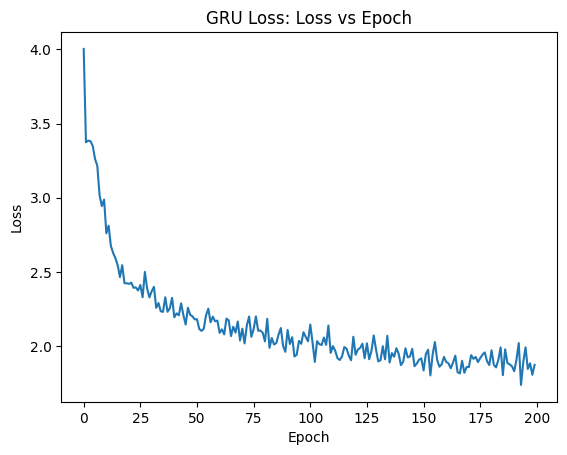

In [25]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005
max_length = len(all_characters)

# Replace the RNN module with your implemented GRUcell
class GRU_RNN(RNN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Replace wtih your gru cell
        self.rnn_cell = GRUCell(max_length, hidden_size, max_length)

decoder = GRU_RNN(max_length, hidden_size, max_length)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)

all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*get_random_chunk(file),decoder)
    loss_avg += loss

    if epoch % print_every == 0:
        print(f"[({epoch} {epoch / n_epochs * 100}%) {loss}]")
        print(evaluate(decoder, 'Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

print(f"______________________________________________________________")
print(evaluate(decoder, 'Th', 200, temperature=0.2))

plt.plot(all_losses)
plt.title("GRU Loss: Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()